# MNIST - Digit Recognizer

Notebook to classify the MNIST network.

## Import libraries


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
import os
from imgaug import augmenters as iaa

from IPython import display

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing

from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils

from file_operations import mnist_to_pdseries, write_results
from neural_networks import simple_nn, convolution_nn

## Set globals

In [5]:
DATA_FOLDER = '../Joan/data/'
RESULTS_FOLDER = '../Michel/results/'

## Read data

Size X_train: (42000, 784)
Size y_train: (42000,)
Size X_test: (28000, 784)


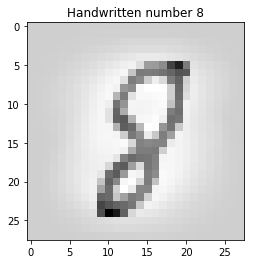

In [61]:
X_train, y_train, X_test = mnist_to_pdseries(DATA_FOLDER)
print('Size X_train: {0}'.format(X_train.shape))
print('Size y_train: {0}'.format(y_train.shape))
print('Size X_test: {0}'.format(X_test.shape))

# show (pseudo-)random picture from the training data.
sample_idx = random.randint(0, X_train.shape[0])
sample = X_train[sample_idx]
plt.imshow(sample.reshape((28, 28)), cmap='Greys', interpolation='nearest')
plt.title('Handwritten number {0}'.format(y_train[sample_idx]))
plt.show()

## Preprocessing

#### Rescaling

In [64]:
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Reshaping

In [65]:
# reshape vectors to one-hot
y_train = np_utils.to_categorical(y_train)
y_train_val = np_utils.to_categorical(y_train_val)
y_test_val = np_utils.to_categorical(y_test_val)

# reshape matrices to greyscale (so depth of 1) 2d images of 28 by 28 pixels
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
X_train_val = np.array(X_train_val).reshape(X_train_val.shape[0], 1, 28, 28).astype('float32')
X_test_val = np.array(X_test_val).reshape(X_test_val.shape[0], 1, 28, 28).astype('float32')

#### Data augmentation

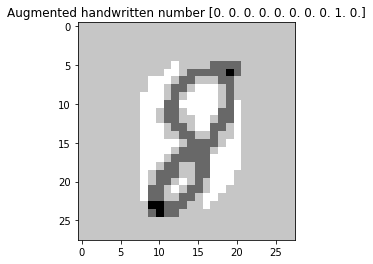

In [77]:
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 1.0)), # blur images with a sigma of 0 to 3.0
    iaa.ContrastNormalization((0.75, 1))
])
augmented_images = seq.augment_images(X_train)

# show the augmented picture derived from the sample
augmented_sample = augmented_images[sample_idx]
plt.imshow(augmented_sample.reshape((28, 28)), cmap='Greys', interpolation='nearest')
plt.title('Augmented handwritten number {0}'.format(y_train[sample_idx]))
plt.show()

In [70]:
aug_X_test = seq.augment_images(X_test)

#### Splitting sets

In [71]:
print('Size X_train: {0}'.format(X_train.shape))
print('Size y_train: {0}'.format(y_train.shape))
print('Size X_test: {0}'.format(X_test.shape))

print('Size X_train_val: {0}'.format(X_train_val.shape))
print('Size y_train_val: {0}'.format(y_train_val.shape))

print('Start splitting now!')

X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.15)

X_train = np.concatenate((X_train, augmented_images))
y_train = np.concatenate((y_train, y_train))
X_train_val = np.concatenate((X_train_val, augmented_images[X_train_val.shape[0]]))
y_train_val = np.concatenate((y_train_val, y_train[:len(y_train_val)]))

print('Size X_train: {0}'.format(X_train.shape))
print('Size y_train: {0}'.format(y_train.shape))
print('Size X_test: {0}'.format(X_test.shape))

print('Size X_train_val: {0}'.format(X_train_val.shape))
print('Size y_train_val: {0}'.format(y_train_val.shape))

## Classify

In [72]:
# set variables
file_dir = './'
network_filepath = os.path.join(file_dir, 'best_model_mnist.h5')

nr_of_classes = y_train_val.shape[1]
epochs = 32
batch_size = 64
learning_rate = 0.0005
optimizer = Adam(lr=learning_rate)

In [73]:
def conv_model(nr_of_classes):
    inputs = Input(shape=(1, 28, 28))
    x = Conv2D(32, (3, 3), activation='relu', data_format='channels_first')(inputs)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(nr_of_classes, kernel_initializer='he_normal', activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    print(model.summary())
    return model

In [74]:
# compile
model = conv_model(nr_of_classes)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy']
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 32, 26, 26)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 26, 26)        104       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 26, 26)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 13, 26)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 11, 64)        15040     
__________

### Learning procedure

In [75]:
def train_network(network, X_train, y_train, X_val, y_val, epochs, batch_size, network_filepath):
    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy
    
    for epoch in range(epochs):
        st = time.time()

        # Train your network
        results = network.fit(X_train_val, y_train_val, batch_size=batch_size)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(X_test_val, y_test_val, batch_size=batch_size)     
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = max(val_accs)
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt], 
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

print(X_train.shape)
print(X_train_val.shape)
print(y_train.shape)

(84000, 1, 28, 28)
(71400, 1, 28, 28)
(84000, 10)


Scores:

without dropout, lr = 0.0005 -> 98.48

dropout - between all layers 0.2 -> 98.45

dropout- all 0.2, last 0.4 - 0.15% test -> 98.41


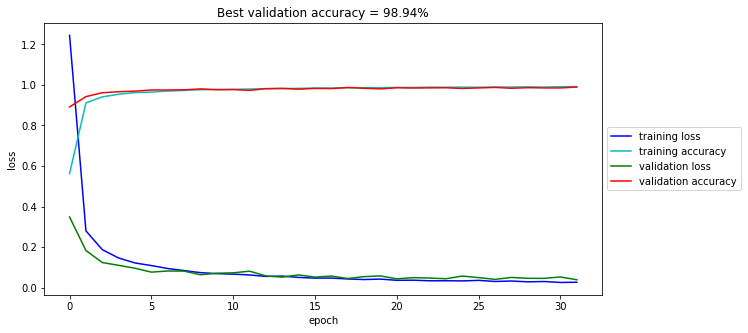

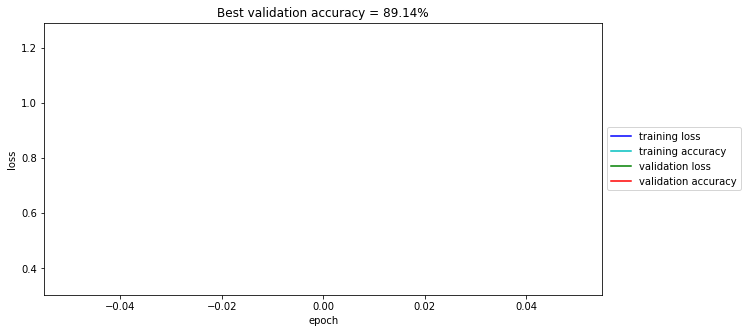

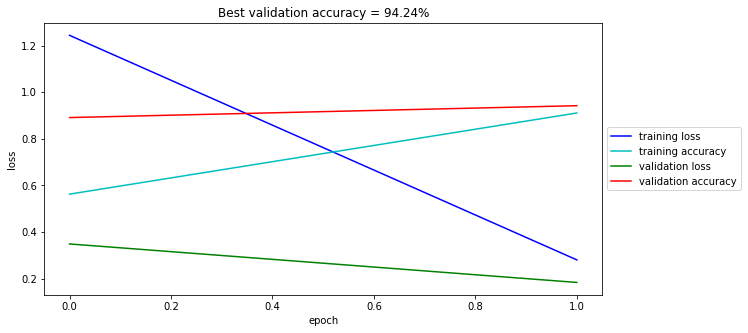

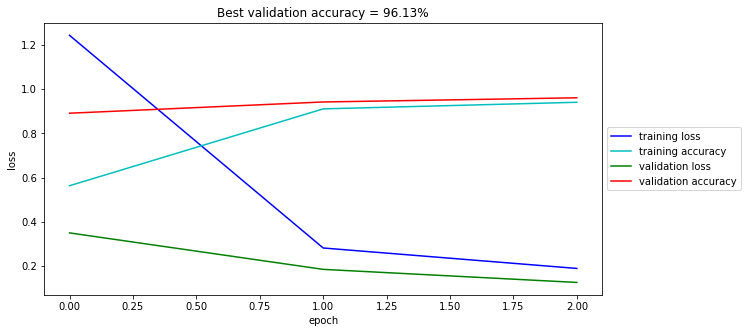

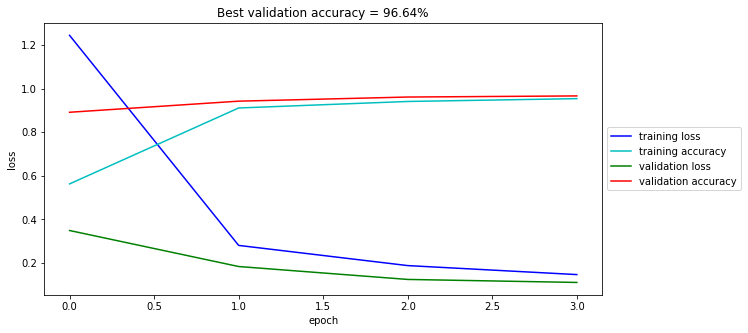

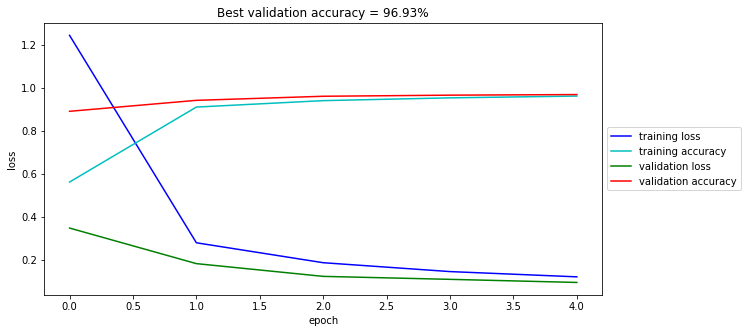

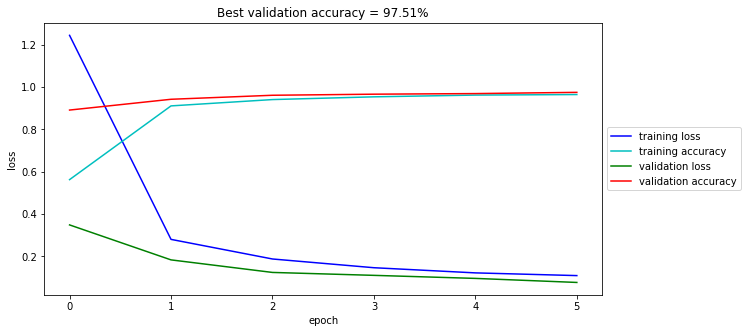

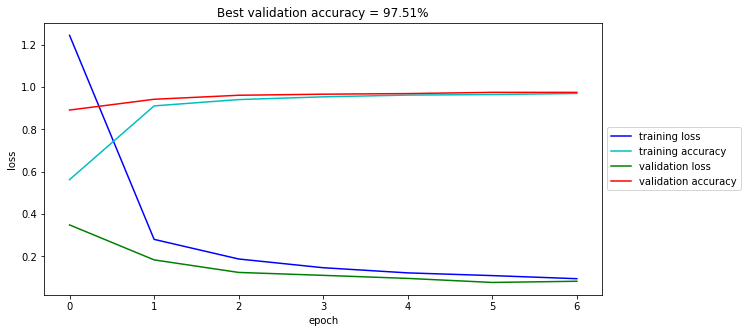

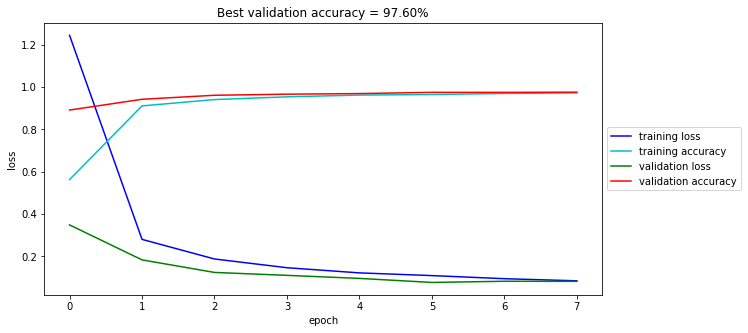

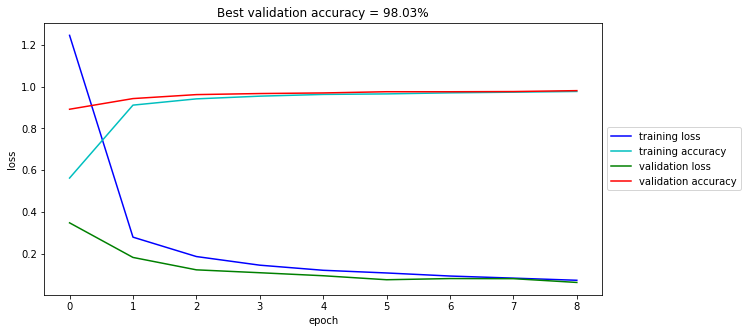

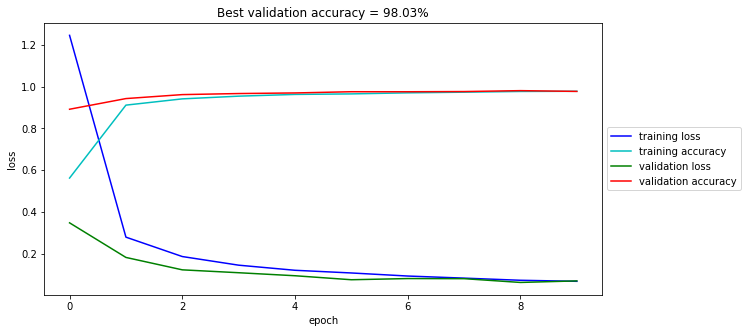

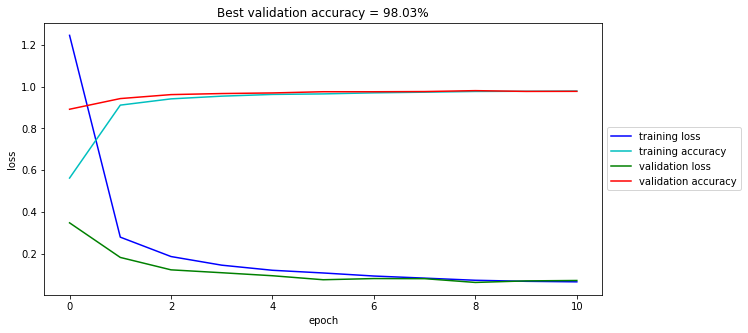

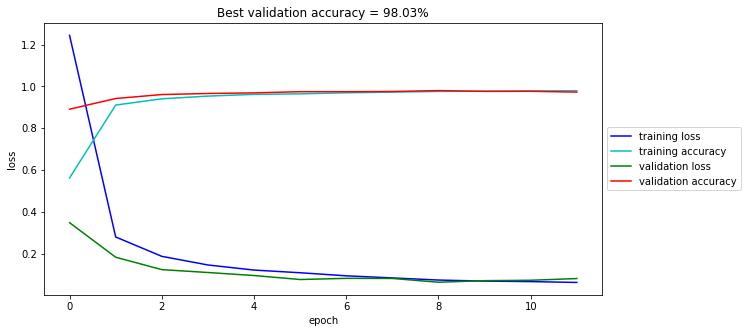

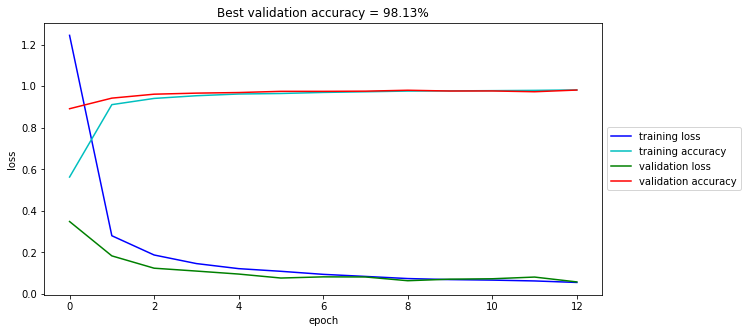

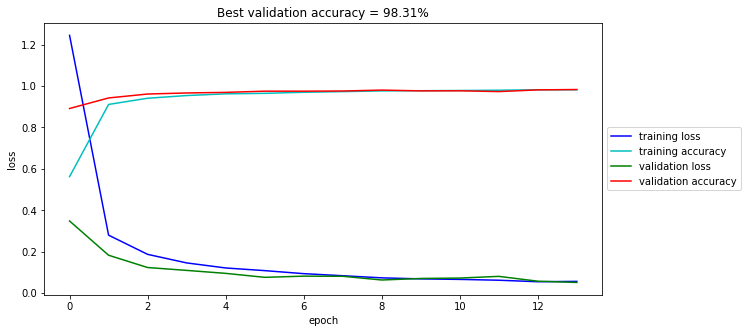

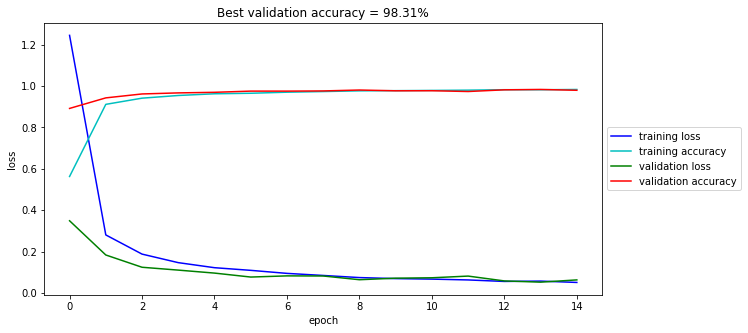

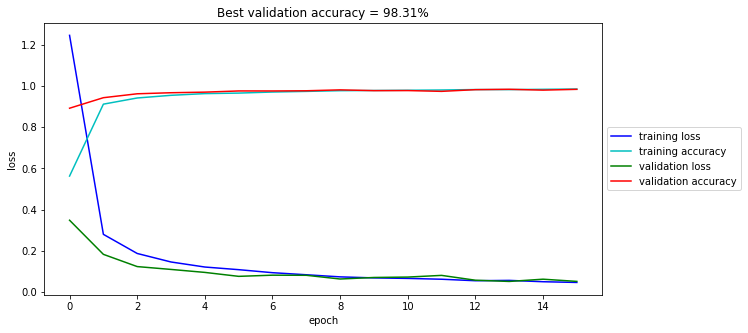

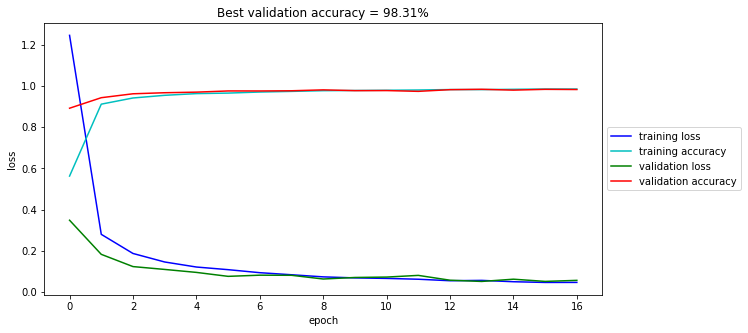

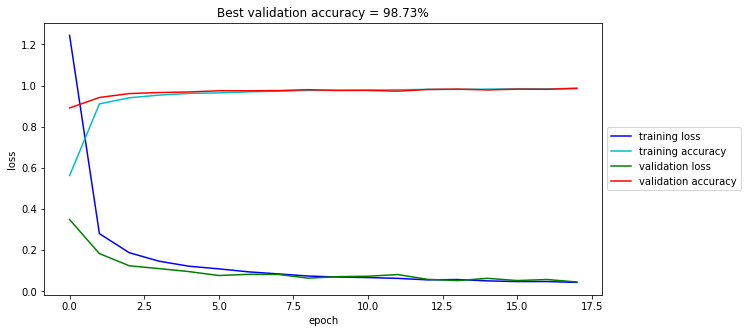

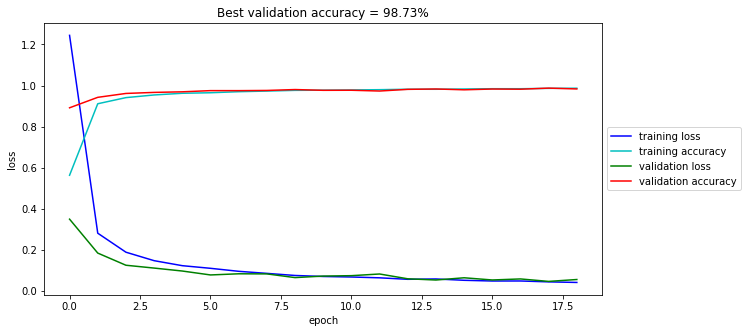

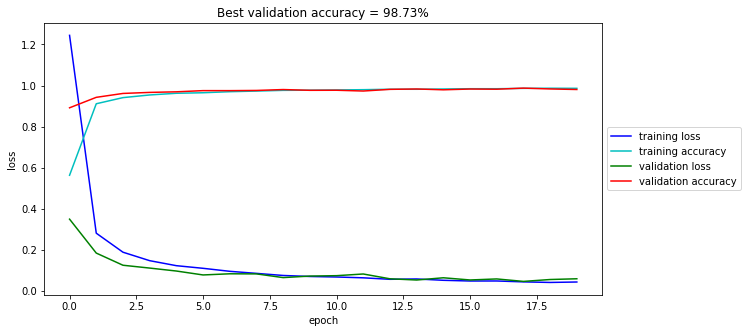

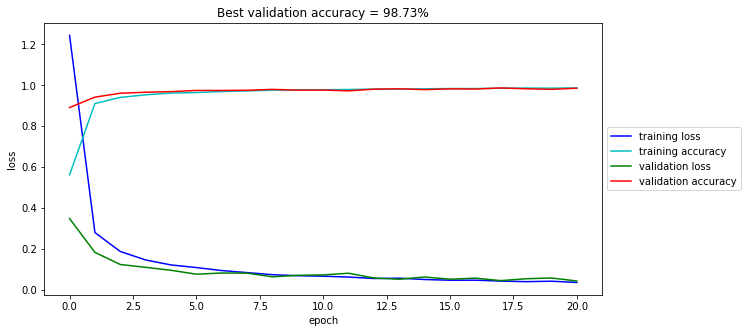

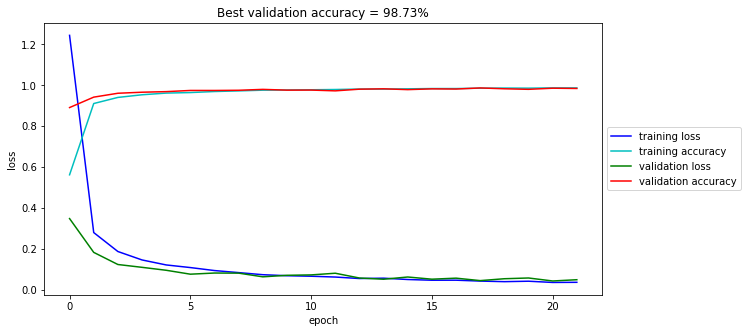

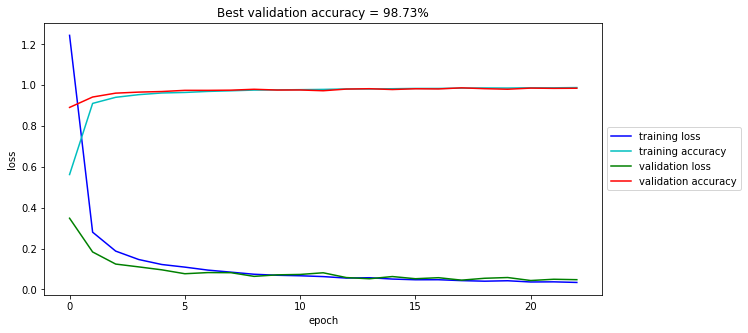

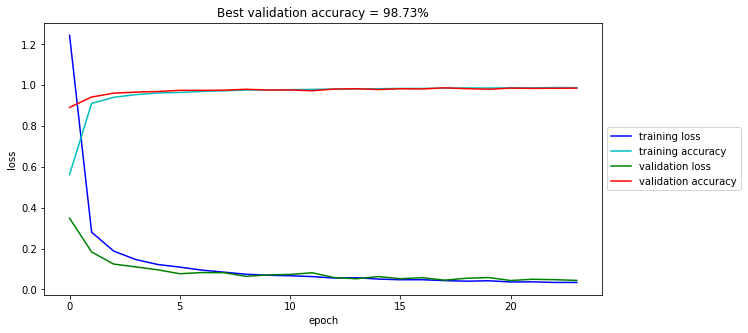

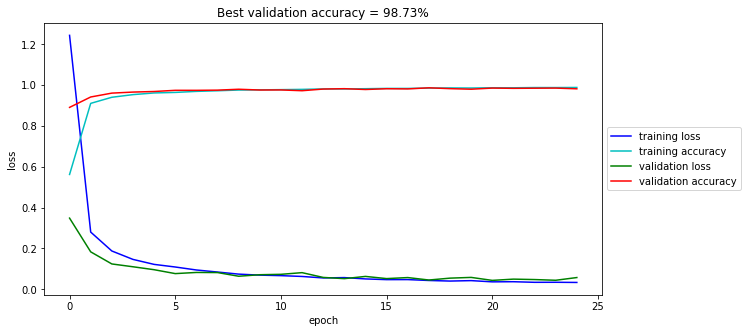

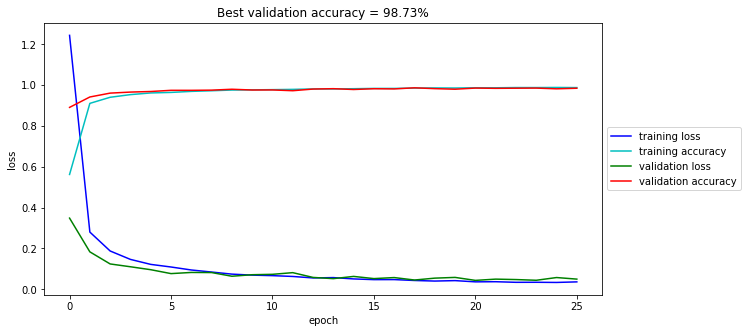

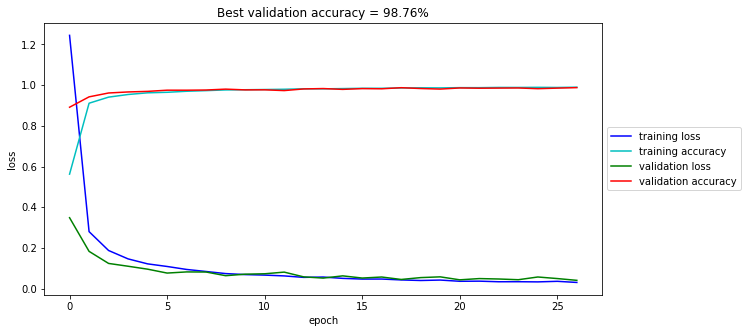

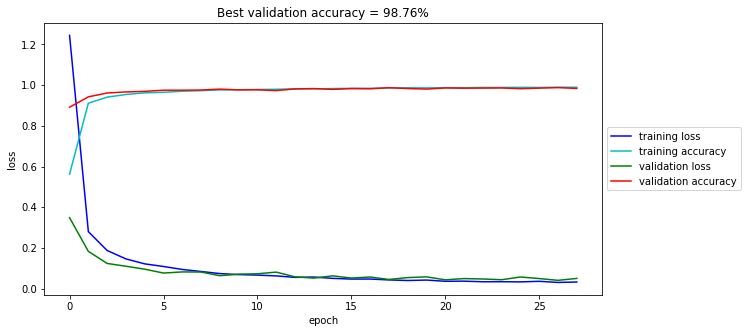

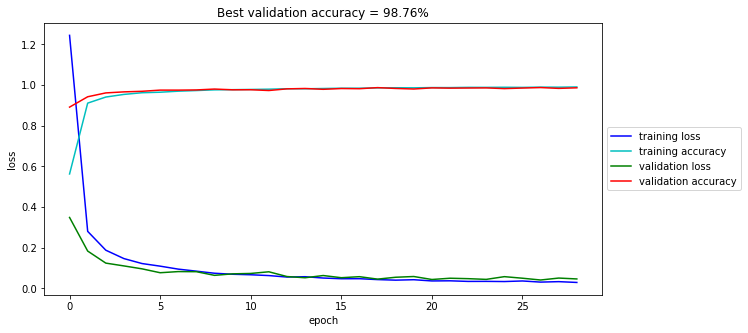

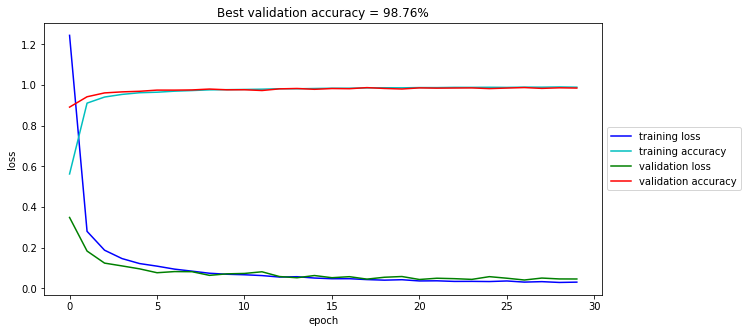

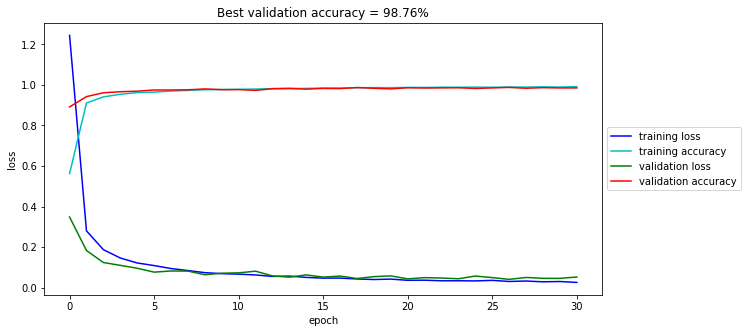

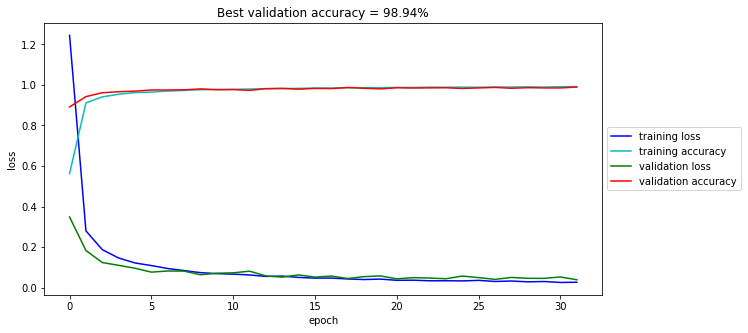

In [76]:
train_network(model, X_train_val, y_train_val, X_test_val, y_test_val, epochs, batch_size, network_filepath)

### Test set classification

In [ ]:
best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
predictions = model.predict(X_test)
predictions = [np.argmax(sample_scores) for sample_scores in predictions]

# write to the results folder
write_results(predictions, RESULTS_FOLDER, 'conv_jup_results')